# Leaky Integrate And Fire Model

In [1717]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import poisson, mode
from typing import List, Tuple
import scipy
from sklearn.decomposition import PCA
from umap.umap_ import UMAP
import math
from scipy.integrate import solve_ivp

In [1718]:
# https://github.com/neural-reckoning/cosyne-tutorial-2022/blob/main/1-lif.ipynb

# https://github.com/markstrefford/Spiking-Neural-Network/blob/master/SNN_0.ipynb

# https://github.com/arnaublanco/Integrate-and-Fire-model/blob/main/Integrate-and-fire%20model.ipynb

## Neuron Model

In [1719]:
class Neuron:
    def __init__(self, v_rest, h, thr, tf, t_ref, lmbda):
        self.v_rest = v_rest
        self.h = h
        self.thr = thr
        self.tf = tf
        self.t_ref = t_ref
        self.lmbda = lmbda
        self.length_v = int(tf / h)
        self.t_ref_i = int(t_ref / h)
        self.v_values = np.zeros(self.length_v)

    def f(self, t, v):
        I_0 = 0.01
        R = 10**4
        tau = 0.02
        dv_dt = (- (v-self.v_rest) + R * I_0)/tau
        return dv_dt

    def euler(self, y0, t0):
        y_values = []
        t = t0
        y = y0
        while y < self.thr:
            t += self.h
            y += self.h * self.f(t, y)
            y_values.append(y)
        return y_values, t
    
    def solve_ode(self, y0, t0):
        sol = solve_ivp(self.f, [t0, self.tf], [y0], method='RK45', t_eval=np.linspace(t0, self.tf, 1000))
        return sol.y[0], sol.t
        
    def identify_neuron_spikes(self, neuron_signal) -> List[int]:
        # the positions of the spikes in the signal
        return [i for i, value in enumerate(neuron_signal) if value >= max(neuron_signal)]

    def simulate(self):
        i = 0
        t = 0
        step = 0
        while i < self.length_v:
            rnd_thr = random.random()
            prob = poisson.cdf(step, mu=self.lmbda)
            step += 1
            if prob < rnd_thr:
                rnd_time = int(self.t_ref_i * 4 * random.random())
                if i + rnd_time < self.length_v:
                    self.v_values[i:i+rnd_time] = self.v_rest
                    i = i + rnd_time
                    t = i * self.h
                else:
                    self.v_values[i:self.length_v] = self.v_rest
                    break
            else:
                v_t, t = self.euler(self.v_rest, t)
                print(t)
                print(v_t)
                new_i = int(round(t / self.h))
                if new_i + self.t_ref_i + 2 <= self.length_v:
                    self.v_values[i:new_i] = v_t
                    i = new_i + 1
                    self.v_values[i] = self.v_values[i-1] + 80
                    i += 1
                    self.v_values[i] = self.v_rest - 10
                    i += 1
                    new_i = i + self.t_ref_i
                    self.v_values[i:new_i] = self.v_rest
                    i = new_i
                    t = i * self.h
                else:
                    self.v_values[i:self.length_v] = self.v_rest
                    break
        return self.v_values


In [1720]:
# from scipy.integrate import solve_ivp

# class Neuron:
#     def __init__(self, v_rest, h, thr, tf, t_ref, lmbda):
#         self.v_rest = v_rest
#         self.h = h
#         self.thr = thr
#         self.tf = tf
#         self.t_ref = t_ref
#         self.lmbda = lmbda
#         self.length_v = int(tf / h)
#         self.t_ref_i = int(t_ref / h)
#         self.v_values = np.zeros(self.length_v)

#     def f(self, t, v):
#         I_0 = 0.005
#         R = 10**4
#         tau = 0.02
#         dv_dt = (- (v-self.v_rest) + R * I_0)/tau
#         return dv_dt

#     def solve_ode(self, y0, t0):
#         sol = solve_ivp(
#             fun=self.f,
#             t_span=[t0, self.tf],
#             y0=[y0],
#             method='RK45',
#             # t_eval=np.linspace(t0, self.tf, int(self.tf / self.h))
#             t_eval=np.linspace(t0, self.tf, 1000)
#         )
#         return sol

#     def identify_neuron_spikes(self, neuron_signal) -> List[int]:
#         # the positions of the spikes in the signal
#         return [i for i, value in enumerate(neuron_signal) if value >= max(neuron_signal)]

#     def simulate(self):
#         i = 0
#         t = 0
#         step = 0
#         while i < self.length_v:
#             rnd_thr = random.random()
#             prob = poisson.cdf(step, mu=self.lmbda)
#             step += 1
#             if prob < rnd_thr:
#                 rnd_time = int(self.t_ref_i * 4 * random.random())
#                 if i + rnd_time < self.length_v:
#                     self.v_values[i:i+rnd_time] = self.v_rest
#                     i = i + rnd_time
#                     t = i * self.h
#                 else:
#                     self.v_values[i:self.length_v] = self.v_rest
#                     break
#             else:
#                 sol = self.solve_ode(self.v_rest, t)  # get solution object
#                 v_t, t = sol.y[0], sol.t  # extract voltages and time points
#                 new_i = len(t)  # get number of time points
#                 if i + new_i + self.t_ref_i + 2 <= self.length_v:
#                     self.v_values[i:i+new_i] = v_t  # insert voltage values
#                     i += new_i  # update index
#                     self.v_values[i] = self.v_values[i-1] + 80
#                     i += 1
#                     self.v_values[i] = self.v_rest - 10
#                     i += 1
#                     new_i = i + self.t_ref_i
#                     self.v_values[i:new_i] = self.v_rest
#                     i = new_i
#                     t = i * self.h
#                 else:
#                     self.v_values[i:self.length_v] = self.v_rest
#                     break
#         return self.v_values


## Grid

In [1721]:
class Grid:
    def __init__(self, size=9, decay_rate=1, signal_length=1, sample_rate=25000, decay_type="square", random_state=None) -> None:
        self.signal_length = signal_length
        self.sample_rate = sample_rate
        self.step_size = 1 / sample_rate
        self.random_state = random_state
        self.decay_type = decay_type
        self.width = size
        self.height = size
        self.decay_rate = decay_rate
        self.neurons_dict = {}
        self.electrode_dict = {}
        self.grid = [[None for _ in range(self.width)] for _ in range(self.height)]
        if self.random_state is not None:
            random.seed(self.random_state)

    def __place_neuron(self, row, col) -> None:
        self.grid[row][col] = "Neuron"

    def __place_electrode(self, empty_grid: List[List], row, col) -> Tuple[int]:
        if empty_grid[row][col] == "Neuron" or empty_grid[row][col] == "Electrode":
            self.__place_electrode(empty_grid)
        else:
            empty_grid[row][col] = "Electrode"
            return row, col
        
    def __calculate_distances(self, x, y):
        """Distance to Neuron"""
        distances = []
        for neuron in self.neurons_dict.keys():
            neuron_x, neuron_y = self.neurons_dict[neuron]["row"], self.neurons_dict[neuron]["col"]
            distances.append(np.sqrt((x - neuron_x)**2 + (y - neuron_y)**2))
        return distances
        
    def __decay_mulitplier(self, distance: float) -> int:
        k = self.decay_rate
        if self.decay_type == "linear":
            return max(0, k - distance)
        elif self.decay_type == "exponential":
            return np.exp(-k * distance)
        elif self.decay_type == "square":
            return k /( distance ** 2)
        elif self.decay_type == "inverse":
            if distance != 0:
                return k / distance
            else:
                return np.inf
        else:
            raise ValueError(f"Unknown decay type: {type}")
        
    def noise(self, signal, noise_stddev: int=0.5, type: str="gaussian"):
        if type == "gaussian":
            return np.random.normal(0, noise_stddev, signal.shape)
        elif type == "none":
            return np.random.normal(0, 0, signal.shape)
        else:
            print(f"Unknown Noise Type: {type}")

    def add_neurons(self, positions: List[Tuple]=False):
        if positions:
            for i, position in enumerate(positions):
                try:
                    row, col = position[0], position[1]
                    self.__place_neuron(row, col)
                    self.neurons_dict[i] = {"row": row, "col": col, "object": Neuron(v_rest=-70, h=self.step_size, thr=-10, tf=self.signal_length, t_ref=0.02, lmbda=14)}
                except:
                    print("Something went wrong placing your neurons")
        else:
            row, col = self.width // 2, self.height // 2
            self.__place_neuron(row, col)
            self.neurons_dict[0] = {"row": row, "col": col, "object": Neuron(v_rest=-70, h=self.step_size, thr=-10, tf=self.signal_length, t_ref=0.02, lmbda=14)}

    def add_electrodes(self, positions: List[Tuple]=False):
        if positions:
            for i, position in enumerate(positions):
                try:
                    row, col = position[0], position[1]

                    # if something already exist at this grid position, give a warning
                    if self.grid[row][col]:
                        print(f"WARNING... There is already a {self.grid[row][col]} at ({row},{col})" )

                    self.__place_electrode(self.grid, row, col)
                    self.electrode_dict[i] = { "row": row, "col": col, "distances": self.__calculate_distances(row, col), "signals": [] }
                except:
                    print("Something went wrong placing your neurons")
        else:
            for i in range(3):
                row, col = random.randint(0, self.width - 1), random.randint(0, self.height - 1)
                self.electrode_dict[i] = { "row": row, "col": col, "distances": self.__calculate_distances(row, col), "signals": [] }
                self.__place_electrode(self.grid, row, col)

    def generate_signals(self):
        if len(self.neurons_dict.keys()) == 0 or len(self.electrode_dict.keys()) == 0:
            raise ValueError("You need both Neurons and Electrodes to record signals")
        
        # stimulate each of the neurons to produce a signal
        for neuron in self.neurons_dict.keys():
            neuron_signal = self.neurons_dict[neuron]["object"].simulate()
            self.neurons_dict[neuron]["signal"] = neuron_signal

            self.neurons_dict[neuron]["spikes"] = self.neurons_dict[neuron]["object"].identify_neuron_spikes(neuron_signal)

            # each electrode records this signal with its intensity depending on the distance from the neuron
            for electrode in self.electrode_dict.keys():
                distance = self.electrode_dict[electrode]["distances"][neuron]
                decay = self.__decay_mulitplier(distance=distance)
                # print("Neuron:", neuron , "Electrode:", electrode, "Distance:", distance)
                self.electrode_dict[electrode]["signals"].append((neuron_signal * decay) + self.noise(neuron_signal, type="none"))
        
        # combine the signals of all of the neurons and combine them (only neccesary if more than one neuron exists)
        if len(list(self.neurons_dict.keys())) > 0:
            for electrode in self.electrode_dict.keys():
                combined_signal = np.zeros_like(self.electrode_dict[electrode]["signals"][0])
                for neuron in self.neurons_dict.keys():
                    combined_signal += self.electrode_dict[electrode]["signals"][neuron]

                self.electrode_dict[electrode]["signal"] = combined_signal

    def plot_grid(self) -> None:
        plt.figure(figsize=(6,6))
        
        # extract neuron and electrode positions
        neuron_positions = [(v["row"], v["col"]) for v in self.neurons_dict.values()]
        electrode_positions = [(v["row"], v["col"]) for v in self.electrode_dict.values()]

        # if there are neurons, plot them
        if neuron_positions:
            neuron_rows, neuron_cols = zip(*neuron_positions) # unzip into x and y coordinates
            plt.scatter(neuron_rows, neuron_cols, color='r', label='Neurons', s=100)

            # add text labels for neurons
            for i, (x, y) in enumerate(neuron_positions):
                plt.text(x, y, f'{i}', fontsize=20)

        # if there are electrodes, plot them
        if electrode_positions:
            electrode_rows, electrode_cols = zip(*electrode_positions) # unzip into x and y coordinates
            plt.scatter(electrode_rows, electrode_cols, color='b', label='Electrodes', s=100)
            # add text labels for electrodes
            for i, (x, y) in enumerate(electrode_positions):
                plt.text(x, y, f'{i}', fontsize=20)

        plt.xlim(0, self.width - 1)
        plt.ylim(0, self.height - 1)
        plt.grid(True)
        plt.legend()
        plt.title("Grid with Neurons and Electrodes")
        plt.show()

    def determine_signal_strengths(self, labels, waveforms, visualise=False):

        # get unique labels
        unique_labels = np.unique(labels)

        # loop through each electrode
        for i in range(waveforms.shape[0]):

            # initialise 'avg_waveform' and 'avg_waveform_peak' keys for this electrode
            self.electrode_dict[i]["avg_waveform"] = {}
            self.electrode_dict[i]["avg_waveform_peak"] = {}
            self.electrode_dict[i]["baseline_to_peak"] = {}

            # get the waveforms for this electrode
            electrode_waveforms = waveforms[i]

            
            # estimate the signal baseline using the mode
            signal_baseline = mode(self.electrode_dict[i]["signal"])[0][0]
            
            # loop through each unique label
            for label in unique_labels:
                
                # get the waveforms for this label at this electrode
                label_waveforms = electrode_waveforms[labels == label]
                
                # compute the average waveform for this label at this electrode
                average_waveform = np.mean(label_waveforms, axis=0)
                
                # store the average waveform info in the electrode_dict
                self.electrode_dict[i]["avg_waveform"][label] = average_waveform

                # store the difference between the average vaeform peak and the signals baseline
                self.electrode_dict[i]["avg_waveform_peak"][label] = np.max(average_waveform) 
                self.electrode_dict[i]["baseline_to_peak"][label] = abs(np.max(average_waveform) - signal_baseline) 

        # show a plot if requested
        if visualise:
            # get the number of unique labels and electrodes
            n_labels = len(unique_labels)
            n_electrodes = len(self.electrode_dict)

            # create a figure with a subplot for each electrode
            fig, axs = plt.subplots(n_electrodes, n_labels, figsize=(n_labels*2, n_electrodes*2))

            # make sure axs is always a 2D array, even when n_electrodes or n_labels is 1
            if n_electrodes == 1:
                axs = axs[np.newaxis, :]
            if n_labels == 1:
                axs = axs[:, np.newaxis]

            # loop through each electrode and each label
            for i in range(n_electrodes):
                for j in range(n_labels):
                    # get the label and average waveform for this subplot
                    label = unique_labels[j]
                    average_waveform = self.electrode_dict[i]["avg_waveform"][label]
                    
                    # plot the average waveform
                    axs[i, j].plot(average_waveform, c="k")
                    
                    # set the title of the subplot to the label
                    axs[0, j].set_title(f'Label {label}')
                    axs[i, 0].set_ylabel(f'Electrode {i}')


            # adjust the layout so that subplots do not overlap
            plt.suptitle("Average Waveform for each Neuron \nIdentified by Each Electrode")
            plt.tight_layout()
            plt.show()
    

In [1722]:
grid = Grid(decay_rate=2, signal_length=1, sample_rate=25000)

# add neurons to the grid -> if no coordinates specified, a single neuron will be placed at the center
# grid.add_neurons()
# grid.add_neurons([(4, 6)])

grid.add_neurons([(4, 4), (6, 2)])

# add electrodes to the grid -> if no coordinates specified, three electrode will be randomly placed
# grid.add_electrodes()
# grid.add_electrodes([(1, 3), (4, 7), (4, 1), (7, 2), (3, 3), (1, 5)])
# grid.add_electrodes([(1, 3), (4, 7), (4, 1), (7, 2)])
grid.add_electrodes([(1, 4), (4, 7), (8, 0)])

# stimulate the neurons and record their emitted signals
grid.generate_signals()

0.5706000000000183
[-69.8, -69.6004, -69.4011992, -69.20239680159999, -69.00399200799679, -68.8059840239808, -68.60837205593283, -68.41115531182096, -68.21433300119732, -68.01790433519493, -67.82186852652454, -67.6262247894715, -67.43097233989255, -67.23611039521276, -67.04163817442233, -66.84755489807348, -66.65385978827733, -66.46055206870078, -66.26763096456338, -66.07509570263426, -65.88294551122898, -65.69117962020653, -65.49979726096612, -65.30879766644419, -65.1181800711113, -64.92794371096907, -64.73808782354713, -64.54861164790003, -64.35951442460423, -64.17079539575502, -63.98245380496351, -63.79448889735359, -63.606899919558884, -63.41968611971976, -63.23284674748032, -63.046381053985364, -62.860288291877396, -62.67456771529364, -62.489218579863056, -62.30424014270333, -62.11963166241792, -61.93539239909309, -61.7515216142949, -61.56801857106631, -61.38488253392418, -61.20211276885633, -61.01970854331862, -60.83766912623199, -60.655993787979526, -60.474681800403566, -60.2937

The position of the neurons and electrodes can be visualised

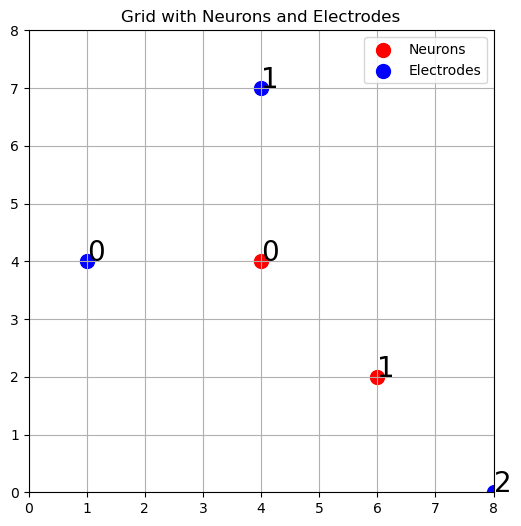

In [1723]:
grid.plot_grid()

We can show how the emitted signal from each neuron is being recorded by each electrode with attenuation noise.

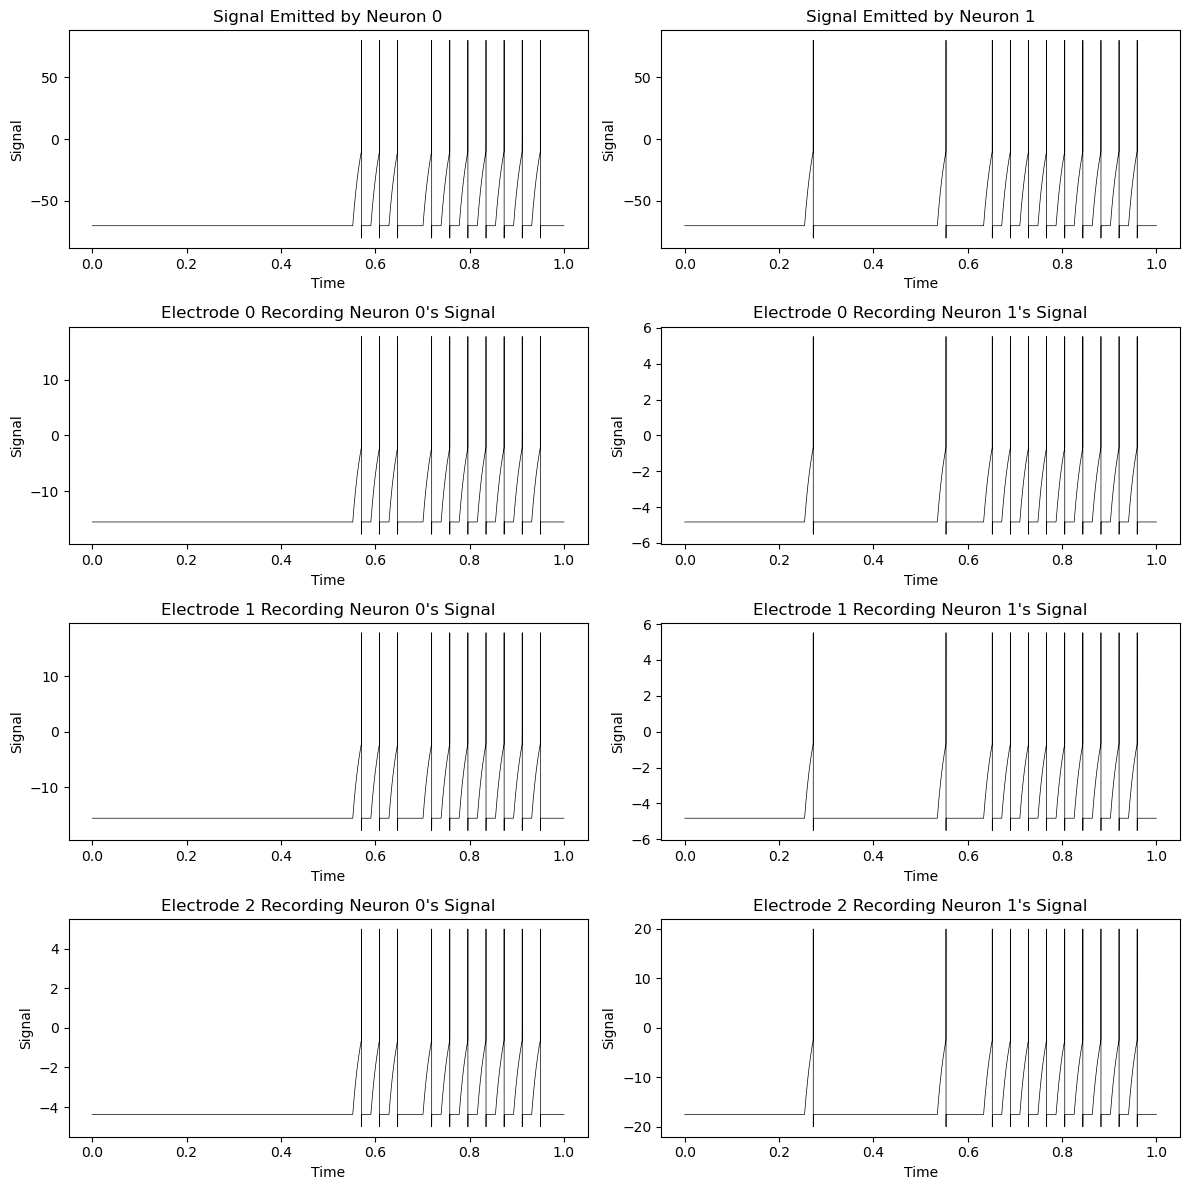

In [1724]:
def plot_signals(grid, neuron_ids, electrode_ids):
    # If neuron_ids is a single value, convert it to a list
    if not isinstance(neuron_ids, list):
        neuron_ids = [neuron_ids]

    # Create a figure with one subplot for each neuron and electrode
    fig, axs = plt.subplots(len(electrode_ids) + 1, len(neuron_ids), figsize=(12, 12))

    # Handle the case where there's only one neuron and multiple electrodes
    if len(neuron_ids) == 1 and len(electrode_ids) > 1:
        axs = np.expand_dims(axs, axis=1)

    # Plot the original signals from the neurons
    for ax, neuron_id in zip(axs[0], neuron_ids):
        neuron_signal = grid.neurons_dict[neuron_id]["signal"]
        spike_locations = grid.neurons_dict[neuron_id]["spikes"]
        time = np.arange(len(neuron_signal)) / grid.sample_rate
        ax.plot(time, neuron_signal, c="k", lw=0.5)
        ax.set_title(f'Signal Emitted by Neuron {neuron_id}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Signal')

    # Plot the recorded signals from the electrodes
    for i, electrode_id in enumerate(electrode_ids, start=1):
        for j, ax in enumerate(axs[i]):
            electrode_signal = grid.electrode_dict[electrode_id]["signals"][neuron_ids[j]]
            time = np.arange(len(neuron_signal)) / grid.sample_rate
            ax.plot(time, electrode_signal, c="k", lw=0.5)
            spike_locations = grid.neurons_dict[j]["spikes"]
            ax.set_title(f"Electrode {electrode_id} Recording Neuron {j}'s Signal")
            ax.set_xlabel('Time')
            ax.set_ylabel('Signal')

    # Adjust the layout and show the plot
    plt.tight_layout()
    plt.show()

plot_signals(grid=grid, neuron_ids=list(grid.neurons_dict.keys()), electrode_ids=list(grid.electrode_dict.keys()))

The signals recorded by each electrode should be a combination of the neurons signals.

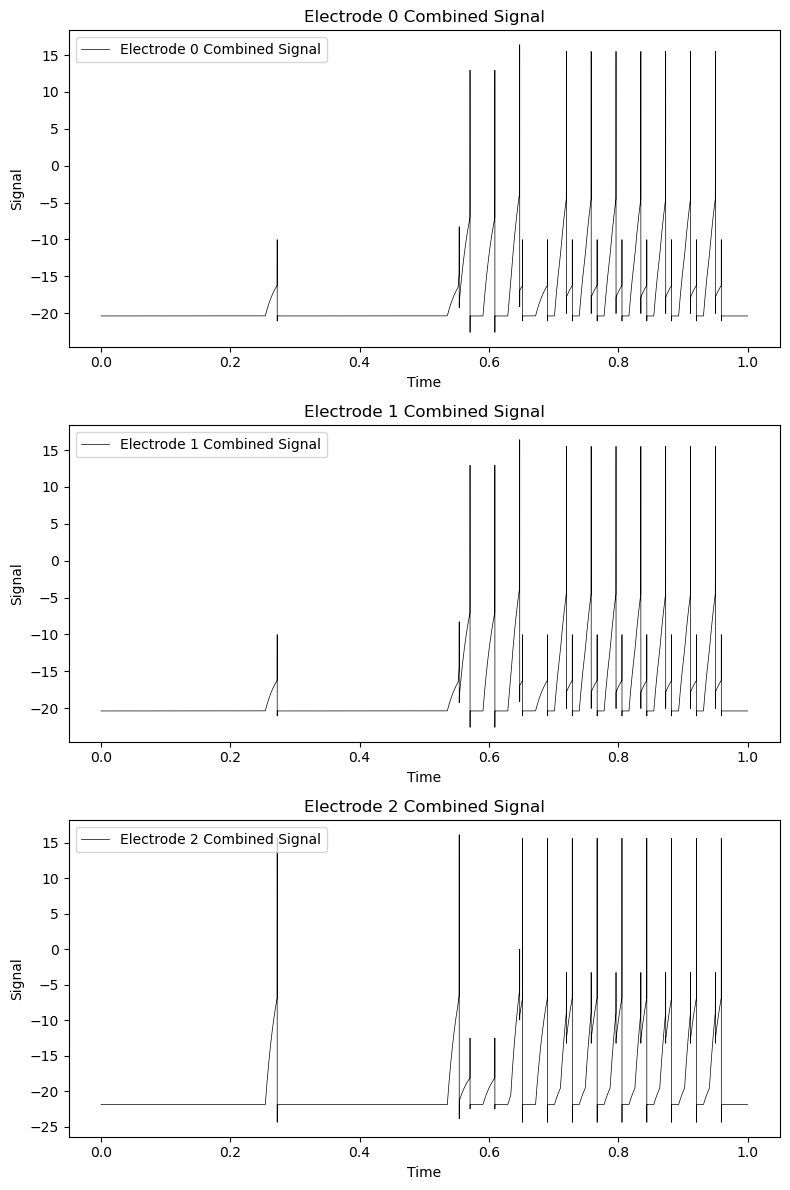

In [1725]:
import matplotlib.pyplot as plt

def plot_combined_signals(grid, electrode_ids, show_spike=False):
    # Create a figure with one subplot for each electrode
    fig, axs = plt.subplots(len(electrode_ids), 1, figsize=(8, 12))

    # Handle the case where there's only one electrode
    if len(electrode_ids) == 1:
        axs = [axs]

    # Plot the combined signals from the electrodes
    for electrode_id, ax in enumerate(axs):
        # Get the combined signal
        combined_signal = grid.electrode_dict[electrode_id]["signal"]

        # Plot the combined signal
        time = np.arange(len(combined_signal)) / grid.sample_rate
        ax.plot(time, combined_signal, label=f'Electrode {electrode_id} Combined Signal', c="k", lw=0.5)
        ax.set_title(f'Electrode {electrode_id} Combined Signal')
        ax.set_xlabel('Time')
        ax.set_ylabel('Signal')
        ax.legend()

    # Adjust the layout and show the plot
    plt.tight_layout()
    plt.show()


plot_combined_signals(grid=grid, electrode_ids=list(grid.electrode_dict.keys()), show_spike=True)

# Spike Identification

In [1726]:
class SpikeSorter():
    def __init__(self, threshold_factor, waveform_duration, sample_rate=1000):
        self.threshold_factor = threshold_factor
        self.sample_rate = sample_rate
        self.dt = 1 / self.sample_rate
        self.waveform_duration = waveform_duration

    ## needs modification
    def filter_signal(self, signal, type, low: int, high: int, order: int):
        # the nyquist frequency
        nyquist = 0.5 * self.sample_rate

        # form upper/lower frequency bounds
        lower = low / nyquist
        upper = high / nyquist

        if type == "bandpass":
            # filter the data using the butterworth filter
            b, a = scipy.signal.butter(order, [lower, upper], btype='band')

            # this compensates for phase shifting as it does forward and backwards pass
            filtered_signal = scipy.signal.filtfilt(b, a, signal, padlen=len(signal)-1)

            return filtered_signal
        else:
            print("Unknown Filter Type: ", type)

    def filter_signals(self, signals, type: str="bandpass", low: int=500, high: int=3000, order: int=4, visualise: bool=True):
        filtered_signals = []
        for signal in signals:
            filtered_signals.append(self.filter_signal(signal=signal, type=type, low=low, high=high, order=order))

        if visualise:
            fig, axs = plt.subplots(len(filtered_signals), 1, figsize=(8, 12))

            if len(filtered_signals) == 1:
                axs = [axs]

            for electrode_id, ax in enumerate(axs):
                filtered_signal = filtered_signals[electrode_id]
                time = np.arange(len(filtered_signal))
                ax.plot(time, filtered_signal, label=f'Electrode {electrode_id} Combined Signal')
                ax.set_title(f'Electrode {electrode_id} Combined Signal')
                ax.set_xlabel('Time')
                ax.set_ylabel('Signal')
                ax.legend()

            plt.tight_layout()
            plt.show()
            
        return filtered_signals
    
    def get_threshold_value(self, signal: np.ndarray, is_negative: bool=False) -> float:
        # calculate robust s.d. using the mean absolute deviation (MAD)
        sigma = np.median(np.abs(signal - np.median(signal)) / 0.6745)

        # set the threshold for this channel
        if is_negative:
            return -1 * self.threshold_factor * sigma # not sure if its always negative??
        else:
            return self.threshold_factor * sigma
    
    def detect_spikes(self, y: np.ndarray, threshold: float, minimum_gap: int=1, use_absolute_threshold: bool=False, flipped: bool=False) -> np.ndarray:
        """
        Detects spikes (or troughs) in a given signal.

        Parameters
        ----------
        y: np.ndarray
            The input signal.
        threshold: float
            The threshold value for spike detection. If `use_absolute_threshold` is False, this is a relative value.
        minimum_gap: int, optional
            The minimum number of samples between spikes. Default is 1.
        use_absolute_threshold : bool, optional
            If True, `threshold` is an absolute value. If False, `threshold` is a relative value. Default is False.
        flipped: bool, optional
            If True, the function will detect troughs (downward spikes) instead of peaks (upward spikes). Default is False.

        Returns
        -------
        np.ndarray
            An array of indices in `y` where spikes were detected.

        Raises
        ------
        ValueError
            If `y` is an unsigned array.

        Notes
        -----
        This function uses a first order difference method to detect spikes. It first computes the first differential of `y`, then finds the indices where the differential changes sign (indicating a peak or trough). It then filters these indices based on the `threshold` value and the `minimum_gap` between spikes.

        If `flipped` is True, the function detects troughs instead of peaks. This is done by reversing the sign of the differential and the `threshold` value.

        The function returns an array of indices in `y` where spikes (or troughs) were detected.
        """

        # Check if y is unsigned array
        if isinstance(y, np.ndarray) and np.issubdtype(y.dtype, np.unsignedinteger):
            raise ValueError("y must be signed")
        
        # Convert relative threshold to absolute if necessary
        if not use_absolute_threshold:
            threshold = threshold * (np.max(y) - np.min(y)) + np.min(y)

        # Compute the first differential
        dy = np.diff(y)

        # Propagate left and right values successively to fill all plateau pixels (no gradient)
        zeros, = np.where(dy == 0)

        # Check if the signal is totally flat
        if len(zeros) == len(y) - 1:
            return np.array([], dtype=np.int64)
        
        # Find the peaks or troughs
        if flipped:
            extrema = np.where((np.hstack([dy, 0.0]) > 0.0) & (np.hstack([0.0, dy]) < 0.0) & (np.less(y, threshold)))[0]
        else:
            extrema = np.where((np.hstack([dy, 0.0]) < 0.0) & (np.hstack([0.0, dy]) > 0.0) & (np.greater(y, threshold)))[0]

        # Handle multiple peaks or troughs, respecting the minimum distance
        if extrema.size > 1 and minimum_gap > 1:
            sorted_extrema = extrema[np.argsort(y[extrema])][::-1]
            rem = np.ones(y.size, dtype=bool)
            rem[extrema] = False

            for extremum in sorted_extrema:
                if not rem[extremum]:
                    sl = slice(max(0, extremum - minimum_gap), extremum + minimum_gap + 1)
                    rem[sl] = True
                    rem[extremum] = False

            extrema = np.arange(y.size)[~rem]

        return extrema

    def __get_true_labels(self, merged_spikes: np.ndarray, neuron_spikes: List[List]) -> List[Tuple]:
        true_labels = []
        for i, neuron in enumerate(neuron_spikes):
            for spike in neuron:
                if spike in merged_spikes:
                    true_labels.append((spike, i))
        

        # ensure the list is returned in order of index
        true_labels = sorted(true_labels, key=lambda x: x[0])
        return [i[1] for i in true_labels]

    def merge_spike_indices(self, spike_indices: np.ndarray[np.ndarray], neuron_spikes: List[List], tolerance: int=1) -> np.ndarray:
        """
        Merge spike indices from multiple channels into a single array. 
        If the points are close together only the midpoint is added.

        Parameters:
        -----------
        spike_indices: list of numpy arrays
            Each numpy array contains spike indices for a single channel.
        tolerance: int, optional
            The maximum distance between spike indices that will be considered as the same spike.
            Indices within this distance will be replaced by their midpoint.

        Returns:
        --------
        numpy array
            A single array of merged spike indices.
        """

        # flatten all indices into a single list
        all_indices = np.concatenate(spike_indices)
        
        # sort the indices
        all_indices.sort()
        
        # initialise the output list with the first index
        merged_indices = [all_indices[0]]
        
        # go through the sorted list and merge indices that are close together
        for index in all_indices[1:]:
            if index - merged_indices[-1] <= tolerance:
                # if the current index is close to the last one in the output list, replace the last one with their average (rounded to nearest integer)
                merged_indices[-1] = round((merged_indices[-1] + index) / 2)
            else:
                # if the current index is not close to the last one, add it to the output list
                merged_indices.append(index)
        
        true_labels = self.__get_true_labels(merged_indices, neuron_spikes)
        
        return np.array(merged_indices, dtype=int), true_labels

    def get_waveforms(self, y: np.ndarray, spike_indices: np.ndarray, window_shift_ratio: float=0.5) -> Tuple[np.ndarray[np.ndarray], List[dict]]:
        """
        Extracts waveforms from a signal at given indices.

        Parameters
        ----------
        y : np.ndarray
            The input signal.
        spike_indices : np.ndarray
            The indices in `y` where spikes were detected.
        duration : int
            The duration of the waveform in milliseconds.
        sample_rate : int
            The sample rate of the signal in Hz.
        window_shift_ratio : float, optional
            The ratio of the window size to shift the window to the left of the spike. Default is 0.5.

        Returns
        -------
        waveforms : np.ndarray
            A nested numpy array of extracted waveforms.
        waveform_info : list of dict
            A list of dictionaries containing information about each extracted waveform.

        Notes
        -----
        The dictionaries of waveform_info contain the starting and finishing index of the waveform, its greatest positive 
        and negative amplitudes and the values of the waveform (corresponding to the data in `waveforms`).
        
        """

        # Calculate the number of samples to extract around each spike
        window_size = int(self.sample_rate * self.waveform_duration / 10000)

        # Calculate the number of samples to shift the window
        shift = int(window_size * window_shift_ratio)

        waveforms = []
        waveform_info = []

        # Iterate over the spike indices
        for i in spike_indices:

            # Calculate the start and end of the window
            start = int(i - shift)
            end = int(start + window_size)

            # Extract the waveform
            waveform = y[start:end]

            # Append the waveform to the list
            waveforms.append(waveform)

            # Store information about the waveform
            spike_info = {
                'spike_start': start,
                'spike_end': end,
                'lowest_value': np.min(waveform),
                'highest_value': np.max(waveform),
                'values': waveform
            }

            waveform_info.append(spike_info)

        # Convert the lists to numpy arrays
        waveforms = np.array(waveforms)

        return waveforms, waveform_info


In [1727]:
signals = [grid.electrode_dict[i]["signal"] for i in grid.electrode_dict.keys()]

In [1728]:
time = np.arange(len(signals[0])) / 10000

# Calculate the time difference between consecutive samples
time_diffs = np.diff(time)

# Calculate the mean time difference
mean_time_diff = np.mean(time_diffs)

# The sample rate is the reciprocal of the mean time difference
sample_rate = 1 / mean_time_diff
sample_rate

10000.0

In [1729]:
sorter = SpikeSorter(threshold_factor=5, sample_rate=10000, waveform_duration=70)

# this needs to be adjusted and the parameters tweaked. And the simulated data doesn't really need filtering
# signals = sorter.filter_signals(signals=signals)

In [1730]:
# initialize spikes as an empty list
spikes = []

# loop through each of the channels
for i, signal in enumerate(signals):
    threshold = sorter.get_threshold_value(signal=signal, is_negative=True)
    # detect spikes in this channel
    spikes_channel = sorter.detect_spikes(signal, threshold, use_absolute_threshold=True)

    # append the detected spikes to the list
    spikes.append(spikes_channel)

print(spikes)

[array([14266, 15226, 16186, 17989, 18949, 19909, 20869, 21829, 22789,
       23749]), array([14266, 15226, 16186, 17989, 18949, 19909, 20869, 21829, 22789,
       23749]), array([ 6811, 13847, 16186, 16299, 17259, 18219, 19179, 20139, 21099,
       22059, 23019, 23979])]


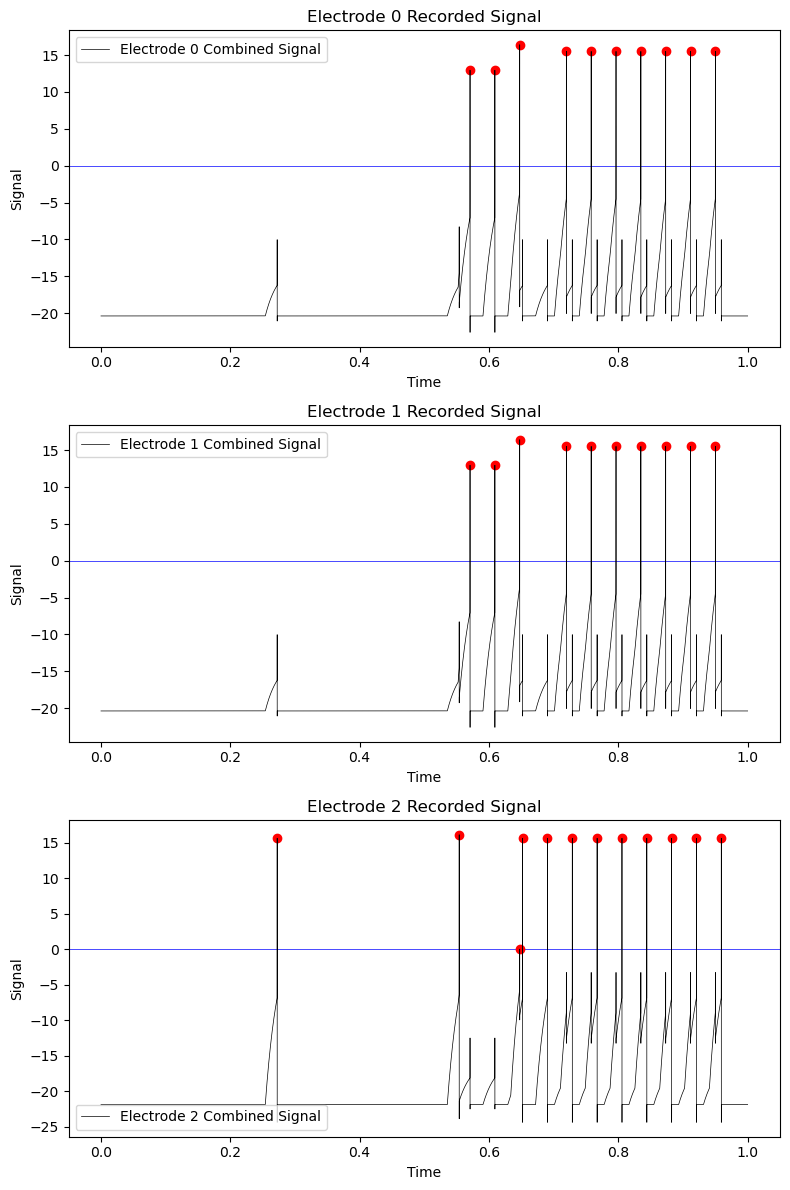

In [1731]:
# Create a figure with one subplot for each electrode
fig, axs = plt.subplots(len(spikes), 1, figsize=(8, 12))

# Handle the case where there's only one electrode
if len(spikes) == 1:
    axs = [axs]

# Plot the combined signals from the electrodes
for electrode_id, ax in enumerate(axs):
    # Get the combined signal
    combined_signal = grid.electrode_dict[electrode_id]["signal"]

    # Plot the combined signal
    # time = np.arange(0, grid.signal_length, 1 / grid.sample_rate)
    time = np.arange(len(combined_signal)) / grid.sample_rate
    ax.plot(time, combined_signal, label=f'Electrode {electrode_id} Combined Signal', c="k", lw=0.5)

    threshold = sorter.get_threshold_value(signal=combined_signal, is_negative=True)
    ax.axhline(y=threshold, c="blue", linewidth=0.5, zorder=0)

    ax.scatter(time[spikes[electrode_id]], combined_signal[spikes[electrode_id]], c="red")

    ax.set_title(f'Electrode {electrode_id} Recorded Signal')
    ax.set_xlabel('Time')
    ax.set_ylabel('Signal')
    ax.legend()

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

In [1732]:
neuron_spikes = [grid.neurons_dict[neuron_id]["spikes"] for neuron_id in grid.neurons_dict.keys()]
spike_indices = np.array(spikes)
merged_spike_indices, true_labels = sorter.merge_spike_indices(spike_indices, neuron_spikes, tolerance=1)

/var/folders/ct/68fpdtpx6lq75x8hr444s83h0000gn/T/ipykernel_2662/3469036481.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spike_indices = np.array(spikes)


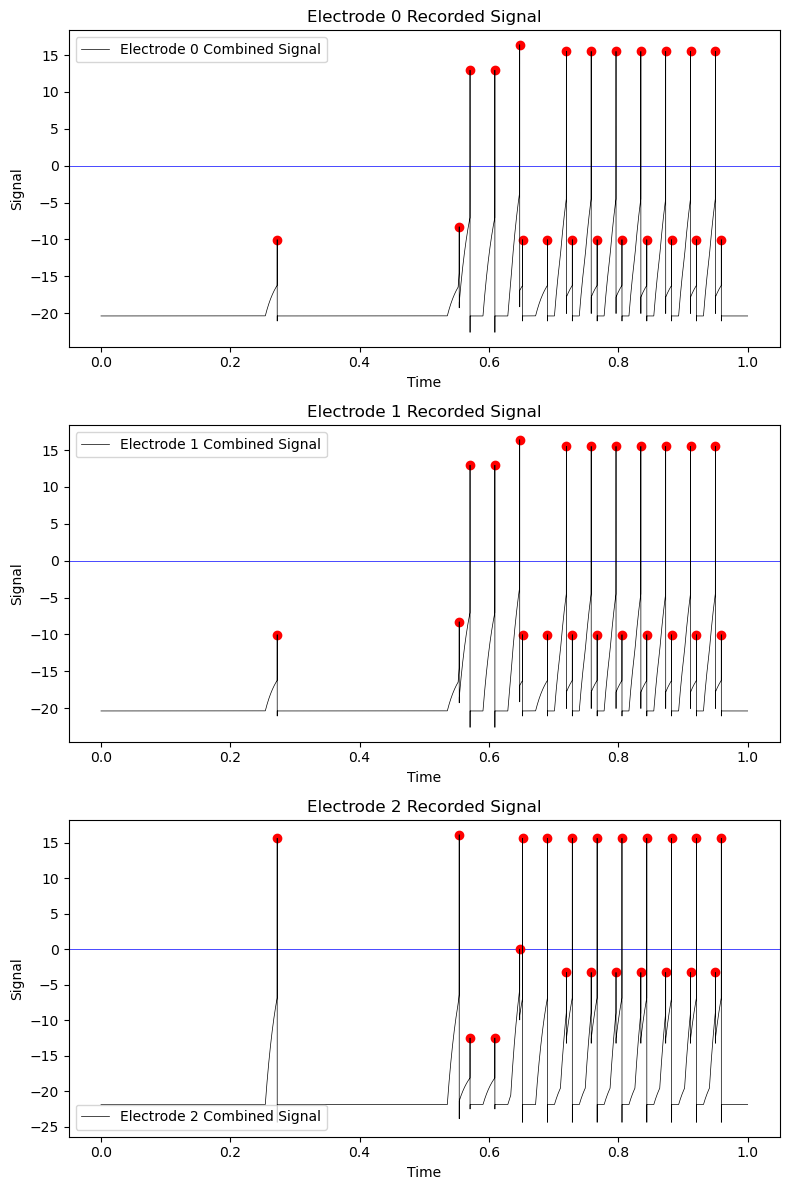

In [1733]:
# Create a figure with one subplot for each electrode
fig, axs = plt.subplots(len(spikes), 1, figsize=(8, 12))

# Handle the case where there's only one electrode
if len(spikes) == 1:
    axs = [axs]

# Plot the combined signals from the electrodes
for electrode_id, ax in enumerate(axs):
    # Get the combined signal
    combined_signal = grid.electrode_dict[electrode_id]["signal"]

    # Plot the combined signal
    time = np.arange(len(combined_signal)) / grid.sample_rate
    ax.plot(time, combined_signal, label=f'Electrode {electrode_id} Combined Signal', c="k", lw=0.5)

    threshold = sorter.get_threshold_value(signal=combined_signal, is_negative=True)
    ax.axhline(y=threshold, c="blue", linewidth=0.5, zorder=0)

    ax.scatter(time[merged_spike_indices], combined_signal[merged_spike_indices], c="red")

    ax.set_title(f'Electrode {electrode_id} Recorded Signal')
    ax.set_xlabel('Time')
    ax.set_ylabel('Signal')
    ax.legend()

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

In [1734]:
waveforms = []
waveform_info = []

# loop through each of the electrode signals
for i, signal in enumerate(signals):

    # get waveforms for this channel
    waveforms_channel, waveform_info_channel = sorter.get_waveforms(y=signal, spike_indices=merged_spike_indices)
    
    # append the waveforms and waveform_info to the lists
    waveforms.append(waveforms_channel)
    waveform_info.append(waveform_info_channel)

# convert waveforms and waveform_info to numpy arrays
waveforms = np.array(waveforms)
waveform_info = np.array(waveform_info)

TypeError: 'AxesSubplot' object is not subscriptable

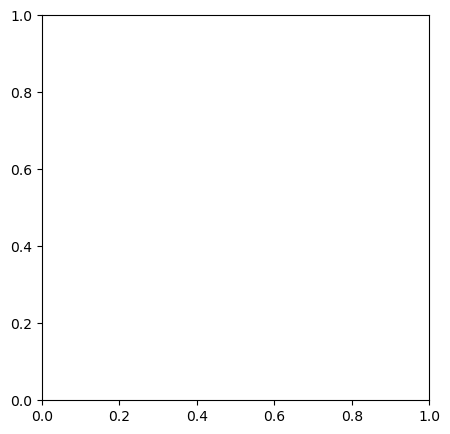

In [1736]:
# determine the number of channels
n_channels = waveforms.shape[0]

# calculate the size of the grid
grid_size = int(np.sqrt(n_channels))

# create a figure and subplots
fig, axs = plt.subplots(grid_size, grid_size, figsize=(5, 5))

# get unique labels
unique_labels = np.unique(true_labels)

# create a colormap
colormap = plt.cm.get_cmap('viridis', len(unique_labels))

# create a dictionary mapping each label to a color
label_to_color = {label: colormap(i) for i, label in enumerate(unique_labels)}

# make sure axs is always an array
if n_channels == 1:
    axs = np.array([[axs]])

# iterate over the channels
for i in range(grid_size):
    for j in range(grid_size):
        channel_idx = i * grid_size + j
        # iterate over the waveforms in this channel and plot each on top of each other
        for idx, waveform in enumerate(waveforms[channel_idx]):
            t = np.arange((- sorter.waveform_duration / 2) / 10, (sorter.waveform_duration / 2) / 10) * sorter.dt * 1000 

            # get the color for this waveform based on its label
            color = label_to_color[true_labels[idx]]

            # plot the waveform
            axs[i, j].plot(t, waveform, lw=.5, c=color)

        axs[i, j].set_xlabel('Time (ms)')
        axs[i, j].set_ylabel('Amplitude')
        axs[i, j].set_title(f'Waveforms (Electrode {channel_idx})')

plt.tight_layout()
plt.show()

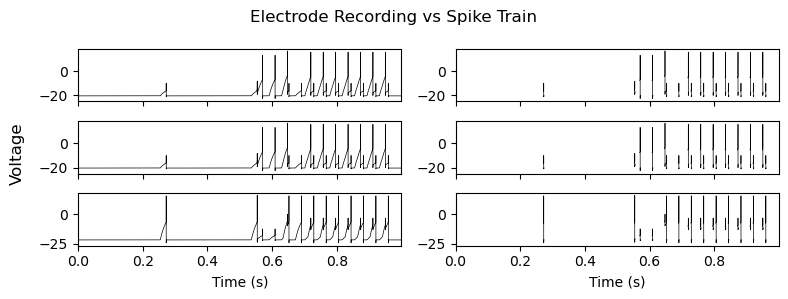

In [1737]:
# determine the number of channels
n_channels =  waveforms.shape[0]

# create a figure and subplots
fig, axs = plt.subplots(n_channels, 2, figsize=(8, 1 * n_channels), sharex=True)

# make sure axs is always an array
if n_channels == 1:
    axs = np.array([[axs]])

# iterate over the channels
for electrode_id in range(n_channels):
    signal = grid.electrode_dict[electrode_id]["signal"]

    # plot the raw data for this channel
    axs[electrode_id, 0].plot(time, np.array(signal), label='Raw Data', c='k', lw=0.5)

    # iterate through each spike and plot its waveform for this channel
    for spike in waveform_info[electrode_id]:
        spike_window = slice(spike["spike_start"], spike["spike_end"])
        axs[electrode_id, 1].plot(time[spike_window], signal[spike_window], c='k', lw=0.5)

    # add x labels to bottom plots
    if electrode_id == n_channels - 1:
        axs[electrode_id, 0].set_xlabel('Time (s)')
        axs[electrode_id, 1].set_xlabel('Time (s)')

    axs[electrode_id, 0].set_ylim((min(signal) + (min(signal) * 0.1) , max(signal) + (max(signal) * 0.1)))
    axs[electrode_id, 1].set_ylim((min(signal) + (min(signal) * 0.1) , max(signal) + (max(signal) * 0.1)))
    axs[electrode_id, 0].set_xlim((0, max(time)))
    axs[electrode_id, 1].set_xlim((0, max(time)))

fig.supylabel("Voltage")
fig.suptitle("Electrode Recording vs Spike Train")
plt.tight_layout()
plt.show()

# Feature Extraction

In [1738]:
print(f"{waveforms.shape} ==> (# electrodes, # Spikes, Spike Window Size)")

(3, 21, 70) ==> (# electrodes, # Spikes, Spike Window Size)


In [1739]:
n_components = 3

b = []
explained_variance_ratios = []
for i in range(waveforms.shape[0]):
    waveform = waveforms[i]

    # initialise PCA
    pca = PCA(n_components=n_components)

    b.append(pca.fit_transform(waveform))

    explained_variance_ratios.append(pca.explained_variance_ratio_)

    # umap = UMAP(n_components=n_components)
    # b.append(umap.fit_transform(waveform))

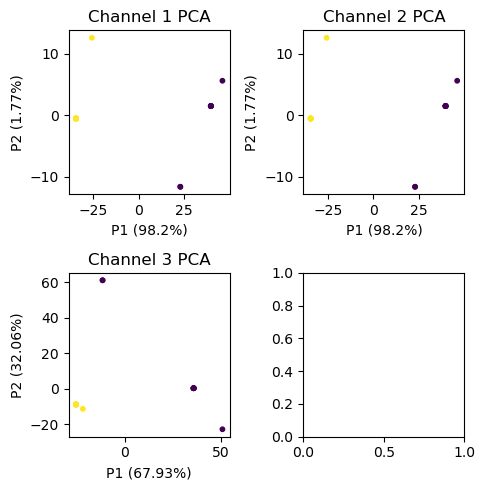

In [1740]:
nrows = 2
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5, 5))

for i, (data, evr) in enumerate(zip(b, explained_variance_ratios)):
    row = i // ncols
    col = i % ncols
    x = [point[0] for point in data]
    y = [point[1] for point in data]

    unique_labels = np.unique(true_labels)
    colormap = plt.cm.get_cmap('viridis', len(unique_labels))
    label_to_color = {label: colormap(i) for i, label in enumerate(unique_labels)}
    colors = [label_to_color[label] for label in true_labels]

    axs[row, col].set_title(f"Channel {i + 1} PCA")
    axs[row, col].set_xlabel(f"P1 ({round(evr[0] * 100, 2)}%)")
    axs[row, col].set_ylabel(f"P2 ({round(evr[1] * 100, 2)}%)")
    axs[row, col].scatter(x, y, s=10, c=colors)

plt.tight_layout()
plt.show()

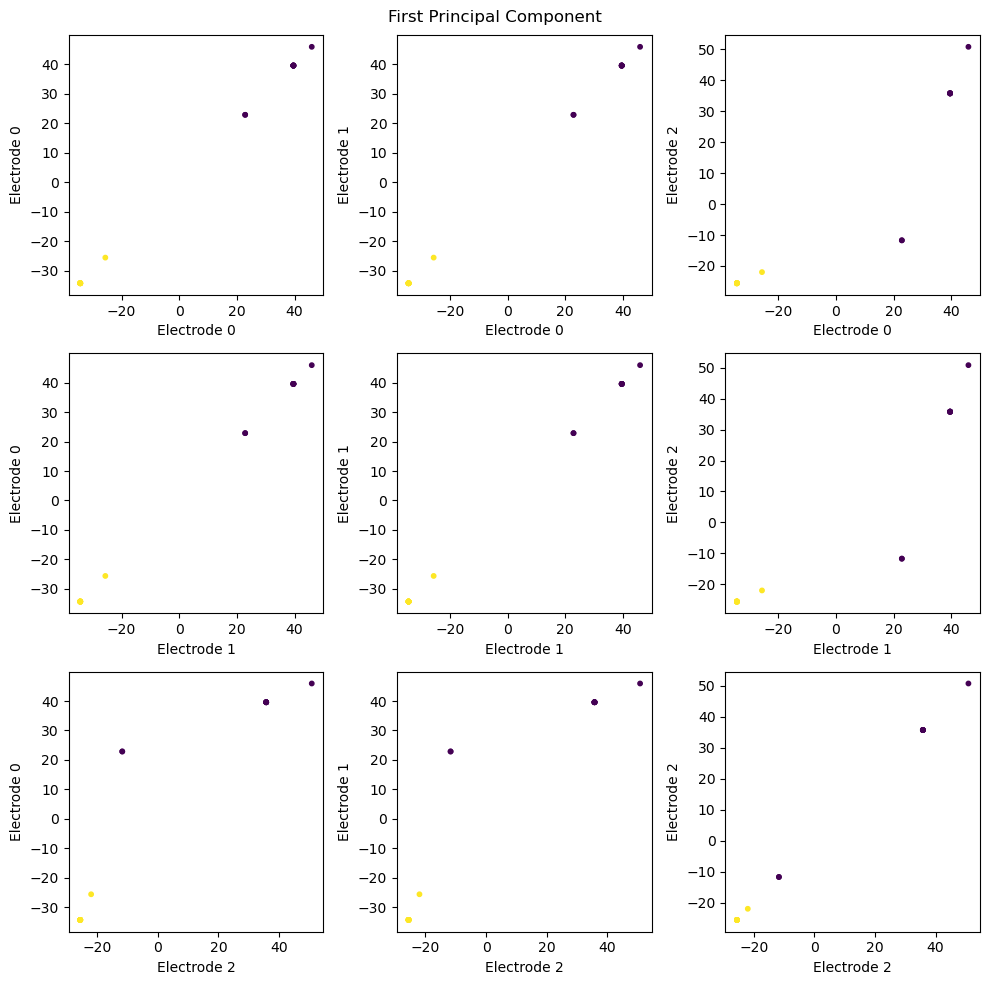

In [1741]:
# Number of channels
num_channels = len(b)

# Create subplots
fig, axs = plt.subplots(num_channels, num_channels, figsize=(10, 10))

# Iterate through each pair of channels
for i in range(num_channels):
    for j in range(num_channels):

        unique_labels = np.unique(true_labels)
        colormap = plt.cm.get_cmap('viridis', len(unique_labels))
        label_to_color = {label: colormap(i) for i, label in enumerate(unique_labels)}
        colors = [label_to_color[label] for label in true_labels]

        # For each subplot, plot the first principal component of channel i against channel j
        axs[i, j].scatter(b[i][:, 0], b[j][:, 0], c=colors, s=10)
        axs[i, j].set_xlabel(f"Electrode {i}")
        axs[i, j].set_ylabel(f"Electrode {j}")

plt.suptitle("First Principal Component")
plt.tight_layout()
plt.show()

# Clustering

In [1742]:
from sklearn.mixture import GaussianMixture 
from sklearn.preprocessing import StandardScaler

def mog(x: np.ndarray, k: int) -> Tuple[np.ndarray]:
    """
    Fit Mixture of Gaussian model
    ind, m, S, p = mog(x, k) fits a Mixture of Gaussian model to the data
    in x using k components. The output ind contains the MAP assignments of the
    datapoints in x to the found clusters. The outputs m, S, p contain
    the model parameters.

    Parameters
    ----------
    x: np.array 
        The datapoints -> N (Number of datapoints) x D (dimensionality of the data)
    k: int
        Number of clusters

    Returns
    ----------
    ind: np.array 
        Cluster indicators
    m: np.array
        Cluster means    (k x D)
    S: np.array 
        Cluster covarience matricies    (D x D x k)
    p: np.array 
        Cluster prior probabilities    (k x 1)
    """
    
    # fit the model
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(x)

    # get the MAP assignments of the data points
    ind = gmm.predict(x)

    # get the model parameters
    m = gmm.means_
    S = gmm.covariances_
    p = gmm.weights_


    return (ind, m, S, p)

from scipy.stats import multivariate_normal

def compute_log_likelihood(x, m, S, p):
    """
    Compute the log-likelihood of the data under the model.

    Parameters:
        x (np.array): N by D
        m (np.array): k by D
        S (np.array): D by D by k
        p (np.array): k by 1

    Returns:
        LL (float): Log-likelihood
    """
    k = m.shape[0]
    n = x.shape[0]
    LL = 0
    for i in range(n):
        temp = 0
        for j in range(k):
            try:
                temp += p[j] * multivariate_normal(m[j], S[j]).pdf(x[i])
            except:
                print(f"Covariance matrix for component {j} is not positive definite:")
                print(S[j])
                return
        LL += np.log(temp)
    return LL

def mog_bic(x, m, S, p):
    """
    Compute the BIC for a fitted Mixture of Gaussian model
    bic, LL = mog_bic(x,k) computes the the Bayesian Information 
    Criterion value and the log-likelihood of the fitted model.

    Parameters:
        x (np.array): N by D
        m (np.array): k by D
        S (np.array): D by D by k
        p (np.array): k

    Returns:
        bic (float): BIC
        LL (float): Log-likelihood
    """
    n, d = x.shape
    k = m.shape[0]

    # Compute the log-likelihood
    LL = compute_log_likelihood(x, m, S, p)

    # Compute the number of parameters
    P = k * (d + (d * (d + 1) / 2) + 1)

    # Compute the BIC
    bic = -2 * LL + P * np.log(n)
    
    return bic, LL

In [1743]:
x = np.array(b)
x = np.transpose(x, (1, 0, 2)).reshape((-1, x.shape[0] * x.shape[2]))

In [1744]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

# ind, m, S, p = mog(x, 6)
# bic, ll = mog_bic(x, m, S, p)

K = [1, 2, 3, 4, 5, 6, 7]
BIC = np.zeros((len(K)))
LL = np.zeros((len(K)))

# loop over the number of clusters
for i, k in enumerate(K):
    # fit the GMM to the data
    ind, m, S, p = mog(x, k)

    # compute the BIC and log-likelihood
    bic, ll = mog_bic(x, m, S, p)

    # store the results
    BIC[i] = bic
    LL[i] = ll

print("BIC: \n", BIC)
print("Log-likelihood: \n", LL)

BIC: 
 [ -801.7130572  -1373.85696705 -1434.93788341 -1422.30463363
 -1374.72614981 -1207.27741574 -1039.82868166]
Log-likelihood: 
 [ 484.58089563  854.3772176   968.64204282 1046.04978496 1105.98491009
 1105.98491009 1105.98491009]


/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/mixture/_base.py:143: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  cluster.KMeans(
/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/mixture/_base.py:143: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  cluster.KMeans(


**The current method of finding optimal number of clusters is wack**

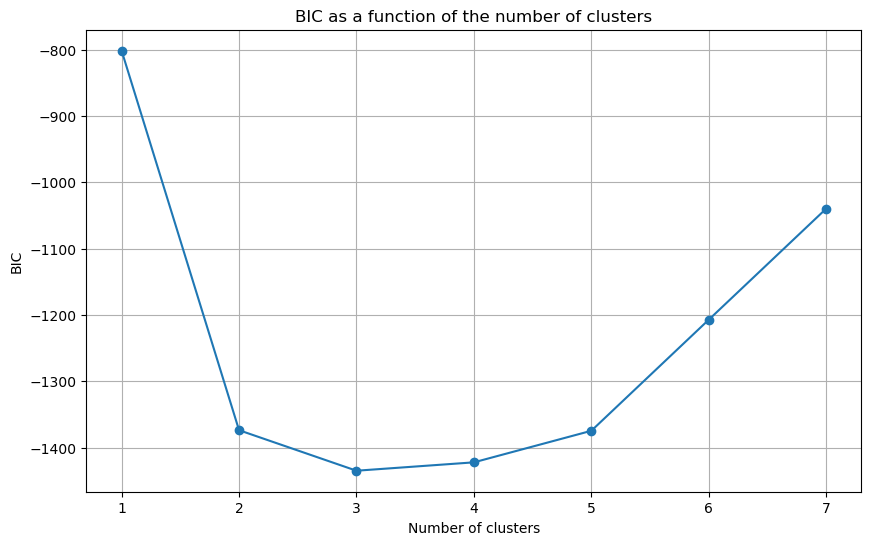

In [1745]:
# plot the BIC as a function of the number of clusters
plt.figure(figsize=(10, 6))
plt.plot(K, BIC, marker='o')
plt.title('BIC as a function of the number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('BIC')
plt.grid(True)
plt.show()

In [1746]:
# optimal_k = K[np.argmin(BIC)]
optimal_k = 2

# # Refit the model with the optimal number of clusters
ind, m, S, p = mog(x, optimal_k)

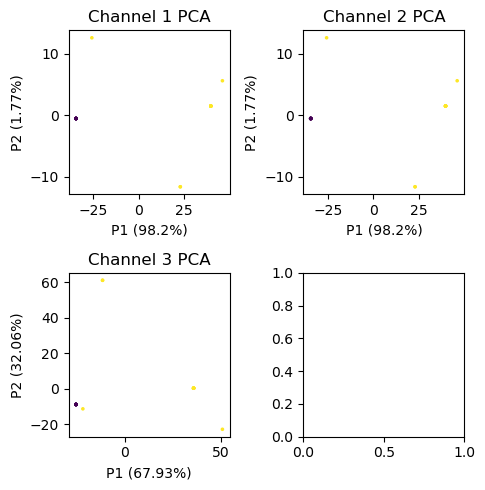

In [1747]:
nrows = 2
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5, 5))

for i, (data, evr) in enumerate(zip(b, explained_variance_ratios)):
    row = i // ncols
    col = i % ncols
    x = [point[0] for point in data]
    y = [point[1] for point in data]
    axs[row, col].set_title(f"Channel {i + 1} PCA")
    axs[row, col].set_xlabel(f"P1 ({round(evr[0] * 100, 2)}%)")
    axs[row, col].set_ylabel(f"P2 ({round(evr[1] * 100, 2)}%)")
    axs[row, col].scatter(x, y, s=10, c=ind, cmap='viridis', marker='.', alpha=1) 

plt.tight_layout()
plt.show()

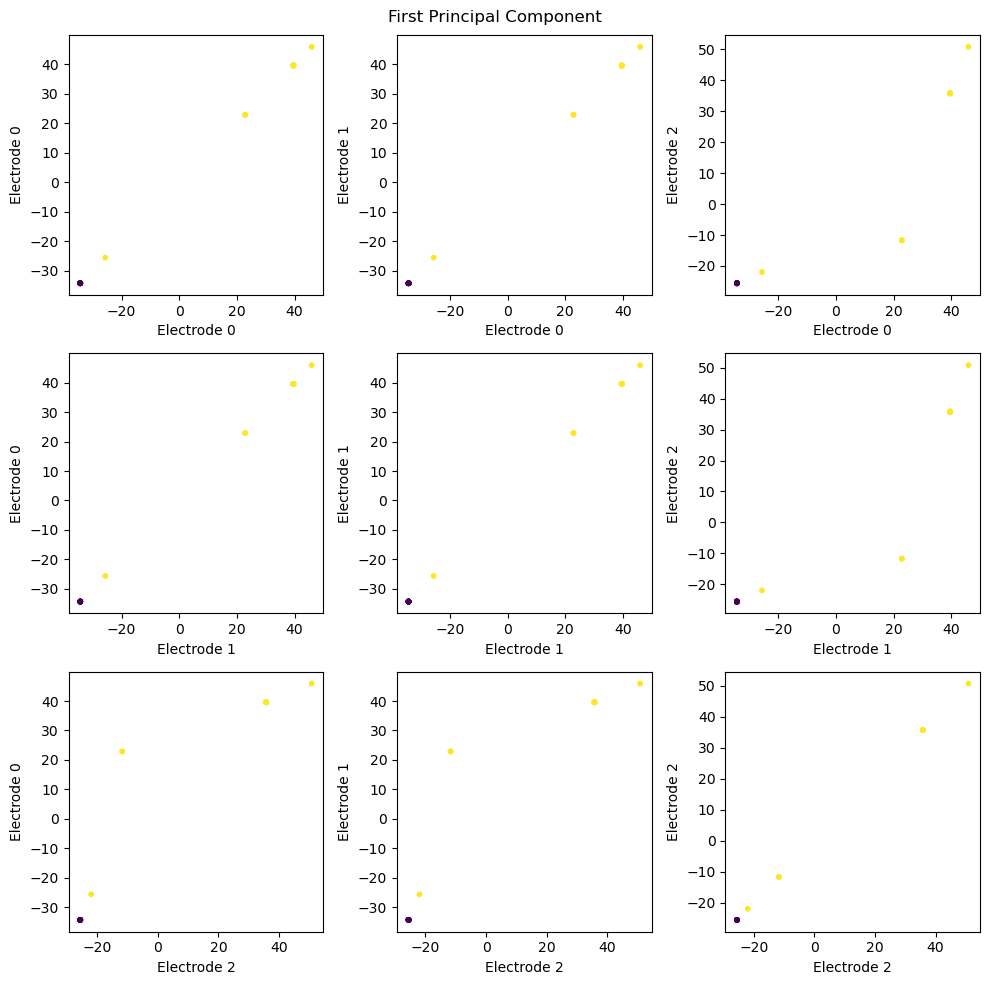

In [1748]:
# Number of channels
num_channels = len(b)

# Create subplots
fig, axs = plt.subplots(num_channels, num_channels, figsize=(10, 10))

# Iterate through each pair of channels
for i in range(num_channels):
    for j in range(num_channels):
        
        # For each subplot, plot the first principal component of channel i against channel j
        axs[i, j].scatter(b[i][:, 0], b[j][:, 0], c=ind, s=10, label=ind)
        axs[i, j].set_xlabel(f"Electrode {i}")
        axs[i, j].set_ylabel(f"Electrode {j}")

plt.suptitle("First Principal Component")
plt.tight_layout()
plt.show()

In [1749]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(true_labels, ind.tolist())
precision = precision_score(true_labels, ind.tolist(), average="weighted")
recall = recall_score(true_labels, ind.tolist(), average="weighted")
f1 = f1_score(true_labels, ind.tolist(), average="weighted")

print(f"Accuracy: {accuracy} \nPrecision: {precision} \nRecall: {recall} \nF1: {f1}")                

Accuracy: 0.047619047619047616 
Precision: 0.047619047619047616 
Recall: 0.047619047619047616 
F1: 0.047619047619047616


## Distance

Calculate the strength of each neuron's signal on each electrode by determining the mean peak amplitude of each spike.

/var/folders/ct/68fpdtpx6lq75x8hr444s83h0000gn/T/ipykernel_2662/3584217548.py:169: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  signal_baseline = mode(self.electrode_dict[i]["signal"])[0][0]


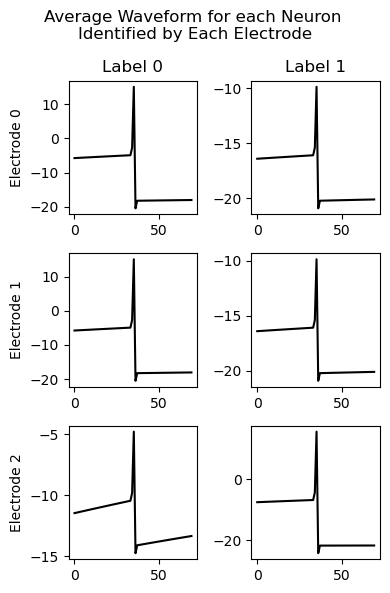

In [1750]:
grid.determine_signal_strengths(true_labels, waveforms, visualise=True)

In [1751]:
grid.electrode_dict[0]["avg_waveform_peak"]

{0: 15.076965870866132, 1: -9.879114815890015}

* For each neuron, choose the 3 electrodes with the largest signal strengths
* Use the electrode with the strongest signal as the reference, compute the ratio signal 1 against signal 2 and use this to compute the line of relative distance between the electrodes and the neuron.
* Do the same using the first and third electrodes.
* The point of intersection between these two lines is the location of the neuron.

In [1752]:
def draw_circle(plot, point, radius):
    x, y = point[0], point[1]
    return plot.Circle((x, y), radius, fill=False, edgecolor='grey')

def plot_grid(self, pairs, perpendicular_lines, neuron_id, intersection_coords, circle_info) -> None:
    fig, ax = plt.subplots(figsize=(6,6))
    
    # extract neuron and electrode positions
    neuron_positions = [(v["row"], v["col"]) for v in self.neurons_dict.values()]
    electrode_positions = [(v["row"], v["col"]) for v in self.electrode_dict.values()]

    # if there are neurons, plot them
    if neuron_positions:
        neuron_rows, neuron_cols = zip(*neuron_positions) # unzip into x and y coordinates
        plt.scatter(neuron_rows, neuron_cols, color='r', label='Neurons', s=100)

        # add text labels for neurons
        for i, (x, y) in enumerate(neuron_positions):
            plt.text(x, y, f'{i}', fontsize=20)

    # if there are electrodes, plot them
    if electrode_positions:
        electrode_rows, electrode_cols = zip(*electrode_positions) # unzip into x and y coordinates
        plt.scatter(electrode_rows, electrode_cols, color='b', label='Electrodes', s=100)
        # add text labels for electrodes
        for i, (x, y) in enumerate(electrode_positions):
            plt.text(x, y, f'{i}', fontsize=20)

    # draw lines for each pair
    for pair in pairs:
        point1, point2 = pair
        plt.plot([point1[0], point2[0]], [point1[1], point2[1]], 'k-')

    # draw the perpendicular lines
    for slope, intercept in perpendicular_lines:
        x = np.linspace(0, self.width, 1000)
        y = slope * x + intercept
        plt.plot(x, y, c="blue", lw=0.5)

    # plot the intersection point
    plt.scatter(intersection_coords[0], intersection_coords[1], c="purple", s=100, label="Estimated Position")

    # plot circles
    for info in circle_info:
        circle = draw_circle(plt, info[0], info[1])
        ax.add_patch(circle)

    plt.xlim(0, self.width - 1)
    plt.ylim(0, self.height - 1)
    plt.grid(True)
    plt.legend()
    plt.title(f"Identifying Neuron {neuron_id} Location")
    plt.show()


(5.5, 8.5)
(2.5, 5.5)
Original Line  ==>  y = 1.0x + 3.0, through point (2.5, 5.5)
Perpendicular Line  ==>  y = -1.0x + 8.0
(5.63888610070919, 4.131949323758917)
Original Line  ==>  y = -1.75x + 14.0, through point (5.63888610070919, 4.131949323758917)
Perpendicular Line  ==>  y = 0.5714285714285714x + 0.9097286947822374


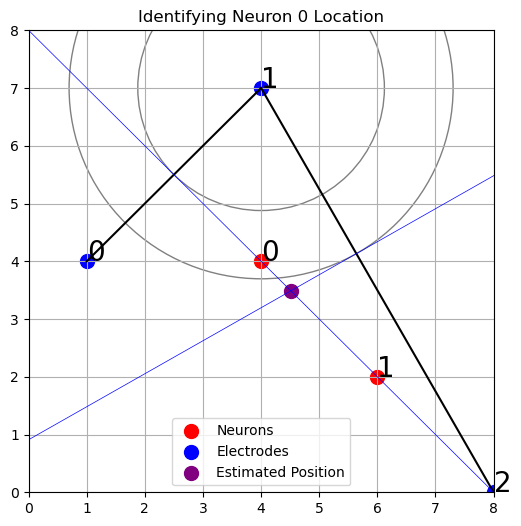


(9.38380161863746, -2.4216528326155533)
(6.616198381362541, 2.4216528326155533)
Original Line  ==>  y = -1.75x + 14.0, through point (6.616198381362541, 2.4216528326155533)
Perpendicular Line  ==>  y = 0.5714285714285714x + -1.3590319567344702
(10.42165283261555, -1.3838016186374569)
(5.57834716738445, 1.3838016186374569)
Original Line  ==>  y = -0.5714285714285714x + 4.571428571428571, through point (5.57834716738445, 1.3838016186374569)
Perpendicular Line  ==>  y = 1.75x + -8.378305924285332


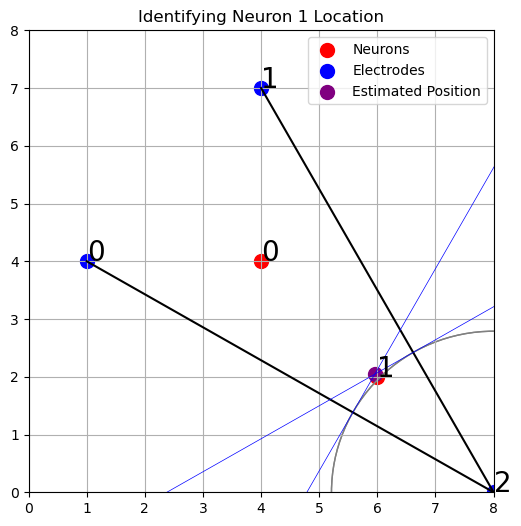

In [1753]:
def signal_strength_ratio(grid, signal_1, signal_2):

    if grid.decay_type == "square":
        ratio = np.sqrt(signal_1 / signal_2)
    else:
        print("Unknown Decay Type:", grid.decay_type)

    return ratio

def is_point_on_line(point, line_point1, line_point2):
    """ Check if a point is on a line between two other points """
    # get the coordinates of the points
    x, y = point
    x1, y1 = line_point1
    x2, y2 = line_point2

    # compute the cross product and the dot product
    cross_product = (y - y1) * (x2 - x1) - (x - x1) * (y2 - y1)
    dot_product = (x - x1) * (x2 - x1) + (y - y1)*(y2 - y1)

    # compute the squared length of the line segment
    squared_length = (x2 - x1)**2 + (y2 - y1)**2

    # check if the point is on the line segment
    if abs(cross_product) > 1e-10 or dot_product < 0 or dot_product > squared_length:
        return False
    else:
        return True

def calculate_perpendicular_equation(distance, point_1, point_2):
    """Distance from first point. Coord of first and second points of line"""
    x_1, y_1, x_2, y_2 = point_1[0], point_1[1], point_2[0], point_2[1]

    # calculate slope of the original line
    if x_2 - x_1 == 0:
        m_original = float('inf')  # use 'inf' to represent an infinite slope
        m_perp = 0
        b_perp = y_1 - distance
    elif y_2 - y_1 == 0:
        m_original = 0
        m_perp = 1
        b_perp = x_1 - distance
    else:
        m_original = (y_2 - y_1) / (x_2 - x_1)
        # calculate the slope of the perpendicular line
        m_perp = -1 / m_original
        # Calculate the intersection point
        d = distance / ((1 + m_original**2)**0.5)
        x = x_1 + d
        y = y_1 + m_original * d

        if not is_point_on_line((x, y), (x_1, y_1), (x_2, y_2)):
            x = x_1 - d
            y = y_1 - m_original * d

        b_perp = y - m_perp * x

        b_original = y_1 - (m_original * x_1)
        # intersection = find_intersection([(m_original, b_original), (m_perp, b_perp)])


    print(f"y = mx + b     =>      y = {m_perp}x + {b_perp}")
    return m_perp, b_perp


def find_intersection(lines):
    line1, line2 = lines[0], lines[1]

    m1, b1 = line1
    m2, b2 = line2

    if m1 == m2:
        print('Lines are parallel and do not intersect.')
        return None
    
    x = (b2 - b1) / (m1 - m2)
    y = m1 * x + b1
    return x, y

def calculate_straight_line(point_1, point_2):
    x_1, y_1, x_2, y_2 = point_1[0], point_1[1], point_2[0], point_2[1]

    if x_2 - x_1 == 0:
        return float('inf'), x_1  # return 'inf' as m and x_1 as 'b' for vertical line
    elif y_2 - y_1 == 0:
        m = 0
        b = y_1
    else:
        m = (y_2 - y_1) / (x_2 - x_1)
        b = y_1 - (m * x_1)

    return m, b

def calculate_perpendicular(point, m_original, b_original):
    print(f"Original Line  ==>  y = {m_original}x + {b_original}, through point {point}")

    x, y = point

    # handle the case of the original line being vertical
    if m_original == float('inf'):
        m_perp = 0
        b_perp = y

    # handle the case of the original line being horizontal
    elif m_original == 0:
        m_perp = float('inf')
        b_perp = x

    # for all other lines
    else:
        m_perp = -1 / m_original
        b_perp = y - m_perp * x

    print(f"Perpendicular Line  ==>  y = {m_perp}x + {b_perp}")
    return m_perp, b_perp


def calculate_tangent(point_1, point_2, radius):
    x_c, y_c = point_1[0], point_1[1]

    # gradient and intercept of line
    m, b = calculate_straight_line(point_1, point_2)

    # coefficients of the quadratic equation
    A = 1 + m**2
    B = 2 * (m * (b - y_c) - x_c)
    C = x_c**2 + (b - y_c)**2 - radius**2

    # calculate the discriminant
    D = B**2 - 4 * A * C

    # list to store the intersections of circle and line
    intersections = []

    # no intersection (shouldn't happen)
    if D < 0:
        print('The line and the circle do not intersect.')
        return None
    # the line is tangent to the circle
    elif D == 0:  
        x = -B / (2 * A)
        y = m * x + b
        intersections.append((x, y))
    # the line intersects the circle at two points
    else:  
        x1 = (-B + D**0.5) / (2 * A)
        y1 = m * x1 + b
        intersections.append((x1, y1))
        x2 = (-B - D**0.5) / (2 * A)
        y2 = m * x2 + b
        intersections.append((x2, y2))
    
    for intersection in intersections:
        print(intersection)
        if is_point_on_line(intersection, point_1, point_2):
            return calculate_perpendicular(intersection, m, b)


# iterate through each of the identified neurons
for neuron_id in range(len(unique_labels)):

    pairs = []
    perpendicular_lines = []
    circle_info = []

    # get the items of the electrode dictionary as a list of tuples
    items = list(grid.electrode_dict.items())

    # sort the electrodes by the strength of the signal recorded
    sorted_items = sorted(items, key=lambda item: item[1]["avg_waveform_peak"][neuron_id])
    sorted_items

    # convert the sorted items back into a dictionary.
    sorted_dict = dict(sorted_items)

    # ids for the electrodes in order of signal strength 
    electrodes_by_strength = list(sorted_dict.keys())[::-1]

    # distance between first electrode (a) and second electrode (b)
    x_a, y_a = grid.electrode_dict[electrodes_by_strength[0]]["row"], grid.electrode_dict[electrodes_by_strength[0]]["col"]
    x_b, y_b = grid.electrode_dict[electrodes_by_strength[1]]["row"], grid.electrode_dict[electrodes_by_strength[1]]["col"]
    d_ab = np.sqrt((x_a - x_b)**2 + (y_a - y_b)**2)
    pairs.append(((x_a, y_a), (x_b, y_b)))

    # ratio of signal strength between the electrodes a and b
    s_a =  grid.electrode_dict[electrodes_by_strength[0]]["baseline_to_peak"][neuron_id]
    s_b =  grid.electrode_dict[electrodes_by_strength[1]]["baseline_to_peak"][neuron_id]

    ab_ratio = signal_strength_ratio(grid, s_a, s_b)

    # neurons distance from electrode a along the line connecting a and b
    r_ab = d_ab / (1 + ab_ratio)
    perpendicular_lines.append(calculate_tangent((x_a, y_a), (x_b, y_b), r_ab))
    circle_info.append(((x_a, y_a), r_ab))

    # distance between first electrode (a) and third electrode (c)
    x_c, y_c = grid.electrode_dict[electrodes_by_strength[2]]["row"], grid.electrode_dict[electrodes_by_strength[2]]["col"]
    d_ac = np.sqrt((x_a - x_c)**2 + (y_a - y_c)**2)
    pairs.append(((x_a, y_a), (x_c, y_c)))

    # ratio of signal strength between the electrodes a and b
    s_c =  grid.electrode_dict[electrodes_by_strength[2]]["baseline_to_peak"][neuron_id]

    ac_ratio = signal_strength_ratio(grid, s_a, s_c)

    # neurons distance from electrode a along the line connecting a and b
    r_ac = d_ac / (1 + ac_ratio)
    perpendicular_lines.append(calculate_tangent((x_a, y_a), (x_c, y_c), r_ac))
    circle_info.append(((x_a, y_a), r_ac))

    intersection_coords = find_intersection(perpendicular_lines)
    plot_grid(grid, pairs, perpendicular_lines, neuron_id, intersection_coords, circle_info)

    print()